<a href="https://colab.research.google.com/github/francomedin/Python-Trading-Algoritmico/blob/main/clase_tester_estrategia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ta


In [ ]:
import pandas as pd
import numpy as np
from ta.trend import SMAIndicator
#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.style 
plt.style.use('ggplot')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Clase TesterBase

In [119]:
class TesterBase():
  def __init__(self,ruta,sma_short,sma_long):
    self.ruta=ruta
    self.sma_short=sma_short
    self.sma_long=sma_long
    self.resultado=None
  
  def obtener_data(self):
    df=pd.read_csv('/content/drive/MyDrive/Datos Colab/' + self.ruta,
                   converters={'Price': lambda x:float(x.replace(',',''))}
                   )
    df['Date']=pd.to_datetime(df['Date'])
    df=df.sort_values('Date')
    df=df.set_index('Date')

    df['retorno']=df['Price'].pct_change()
    df['Sma-short-'+ str(self.sma_short)]=SMAIndicator(df['Price'],int(self.sma_short),True).sma_indicator()
    df['Sma-long-'+ str(self.sma_long)]=SMAIndicator(df['Price'],int(self.sma_long),True).sma_indicator()

    return df

  def estrategia_cruce_smas(self):
    data=self.obtener_data().copy()
    data['posicion']=np.where(data['Sma-short-'+ str(self.sma_short)] > data['Sma-long-'+ str(self.sma_long)],1,-1)
    data.dropna(inplace=True)
    self.resultado=data

  def medidores_riesgo(self):
    df=self.resultado.copy().dropna()
    risk_free=0.017

    df['retorno_instrumento']=df['Price'].pct_change()
    df['retorno_estrategia']=df['posicion'].shift(1) * df['retorno_instrumento']
    df['retorno_instrumento_acumulado']=df['retorno_instrumento'].cumsum().apply(np.exp)
    df['retorno_estrategia_acumulado']=df['retorno_estrategia'].cumsum().apply(np.exp)

    perf=df['retorno_estrategia_acumulado'][-1]
    pct_superado= perf - df['retorno_instrumento_acumulado']
    #CAGR
    numero_anios=len(df) / 360
    CAGR=df['retorno_estrategia_acumulado'][-1] ** (1/numero_anios) -1
    #Volatilidad Anual
    vol=df['retorno_instrumento'].std() * np.sqrt(360)
    #Sharpe Ratio
    sharpe_ratio=(CAGR - risk_free)/ vol
    #Sortino_ratio
    neg_vol=df[df['retorno_instrumento']< 0 ]['retorno_instrumento'].std() * np.sqrt(360)
    sortino_ratio= (CAGR - risk_free)/ neg_vol
    #MDD
    df['max_return_acumulado']=df['retorno_estrategia_acumulado'].cummax()
    df['draw_down']=df['max_return_acumulado'] - df['retorno_estrategia_acumulado']
    df['dd_pct']=df['draw_down']/df['max_return_acumulado']
    mdd=df['dd_pct'].max()
    #Calmar Ratio
    calmar=CAGR/mdd
    #Impresion del texto
    self.resultado=df.copy()
    
    print("RENDIMIENTO DE LA ESTRATEGIA")
    print("-" * 100)
    print("% Superado al Benchmark:__" + str(round((pct_superado*100), 2)) + "%")
    print("CAGR (Rendimiento Anual)__" + str(round((CAGR*100), 2)) + "%")
    print("Volatilidad Anual:________" + str(round((vol*100), 2)) + "%")
    print("Maximum Drawdown:_________" + str(round((mdd*100), 2)) + "%")
    print("Sharpe R._________________" + str(round(sharpe_ratio, 2)))
    print("Sortino R.________________" + str(round(sortino_ratio, 2)))
    print("Calmar R._________________" + str(round(calmar, 2)))
    print("-" * 100)

  def plot_resultados(self):
    if self.resultado is None:

      print('No hay resultados para plotear')

    else:
      self.resultado[['retorno_instrumento_acumulado','retorno_estrategia_acumulado']].plot(figsize=(12,6))

  

In [129]:
tester=TesterBase("BTC_USD Bitfinex Historical Data.csv",5,50)

In [130]:
tester.estrategia_cruce_smas()

In [131]:
tester.medidores_riesgo()

RENDIMIENTO DE LA ESTRATEGIA
----------------------------------------------------------------------------------------------------
% Superado al Benchmark:__Date
2018-11-30        NaN
2018-12-01    1181.15
2018-12-02    1183.19
2018-12-03    1189.41
2018-12-04    1187.38
               ...   
2021-12-25   -1756.63
2021-12-26   -1778.43
2021-12-27   -1771.62
2021-12-28   -1588.49
2021-12-29   -1598.05
Name: retorno_instrumento_acumulado, Length: 1126, dtype: float64%
CAGR (Rendimiento Anual)__126.3%
Volatilidad Anual:________74.66%
Maximum Drawdown:_________45.64%
Sharpe R._________________1.67
Sortino R.________________2.25
Calmar R._________________2.77
----------------------------------------------------------------------------------------------------


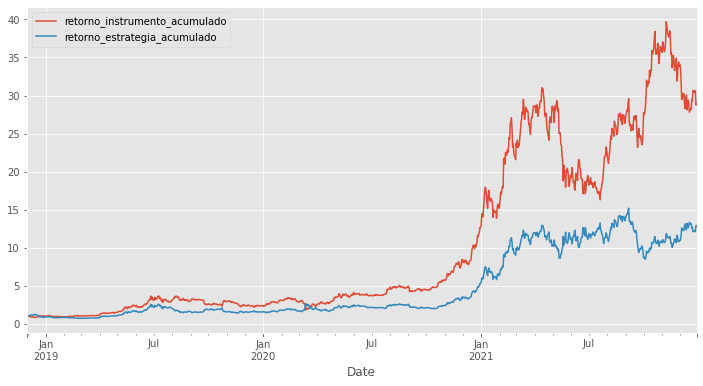

In [132]:
tester.plot_resultados()